In [1]:

from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from torchvision import transforms as tfms
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from torch import autocast
from PIL import Image
import torch
import numpy

# For video display:
from IPython.display import HTML
from base64 import b64encode

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"


2023-03-01 03:57:06.275621: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-01 03:57:06.408183: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-01 03:57:06.427281: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-01 03:57:06.758951: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

# load model

In [ ]:
from utils.model_loader import load_model

config_path = './configs/v1-inference.yaml'
ckpt_path = '../stable-diffusion-webui/models/Stable-diffusion/abyssorangemix2_Hard.safetensors'

model = load_model(config_path, ckpt_path)

# Create Sampler

In [3]:
from ldm.models.diffusion.ddim import DDIMSampler

sampler = DDIMSampler(model)


# Text-to-Image 

the shape of postive text embedding: torch.Size([1, 77, 768])
the shape of negative text embedding: torch.Size([1, 77, 768])
Selected timesteps for ddim sampler: [  1  26  51  76 101 126 151 176 201 226 251 276 301 326 351 376 401 426
 451 476 501 526 551 576 601 626 651 676 701 726 751 776 801 826 851 876
 901 926 951 976]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9757, 0.9505, 0.9229, 0.8930, 0.8607, 0.8264, 0.7901, 0.7521,
        0.7127, 0.6722, 0.6307, 0.5888, 0.5467, 0.5048, 0.4634, 0.4229, 0.3835,
        0.3456, 0.3093, 0.2750, 0.2428, 0.2128, 0.1851, 0.1598, 0.1369, 0.1163,
        0.0980, 0.0819, 0.0679, 0.0557, 0.0453, 0.0365, 0.0292, 0.0231, 0.0181,
        0.0140, 0.0107, 0.0082, 0.0061]); a_(t-1): [0.99914998 0.99829602 0.97565293 0.95052433 0.92294294 0.89298052
 0.86074883 0.82639927 0.79012191 0.75214338 0.71272361 0.67215145
 0.63073969 0.58881873 0.54672998 0.50481856 0.46342579 0.42288151
 0.38349706 0.34555823 0.3093195  0.27499905 0.24277493 0.21278

DDIM Sampler: 100%|██████████| 40/40 [00:09<00:00,  4.01it/s]


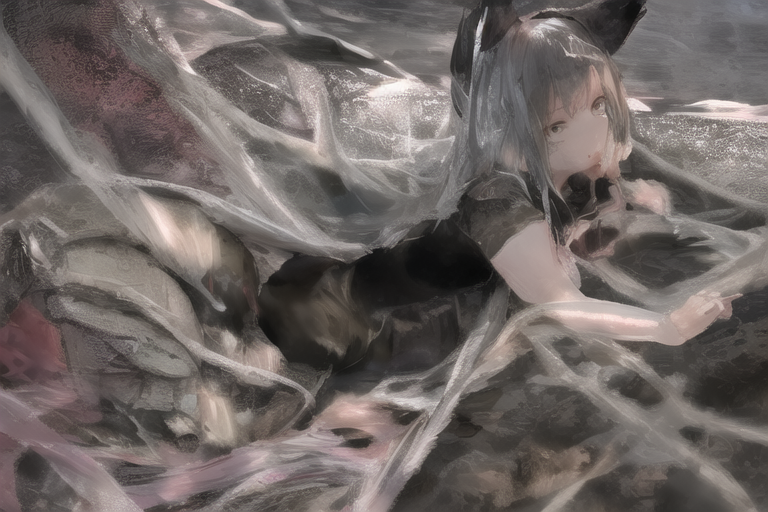

In [4]:

model.to(torch_device)
prompt = ["masterpiece, best quality, loli, animal ears, blue eyes, seduction, sea, wet,  cute face, long hair, white hair, 1girl, sexy,  8K, high resolution,"]
prompt_negative = [""]

height = 512
width = 768

num_inference_steps = 40
guidance_scale = 7.5
batch_size = 1

# Positive Text Embedding
positive_text_embeddings = model.get_learned_conditioning(prompt)
print(f'the shape of postive text embedding: {positive_text_embeddings.shape}')

# Negative Text Embedding
negative_text_embeddings  = model.get_learned_conditioning(prompt_negative)
print(f'the shape of negative text embedding: {negative_text_embeddings.shape}')


image, intermediate = sampler.sample(num_inference_steps, batch_size, (4, height // 8, width // 8), conditioning=positive_text_embeddings, unconditional_conditioning=negative_text_embeddings, guidance_scale=guidance_scale)

image = model.decode_first_stage(image)

# Display
image = (image / 2.0 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]
